## Exploration 11. Stock Price Prediction📊📈

In [1]:
!pip install plotly

In [2]:
import os
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt

### STEP 1 : 시계열 데이터 준비

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/PFE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    34.740002
2021-02-11    34.430000
2021-02-12    34.720001
2021-02-16    34.689999
2021-02-17    34.889999
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

* 결측치 처리
* 로그 변환

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

### STEP 4 : 학습, 테스트 데이터셋 생성

* 학습, 테스트 데이터셋 분리

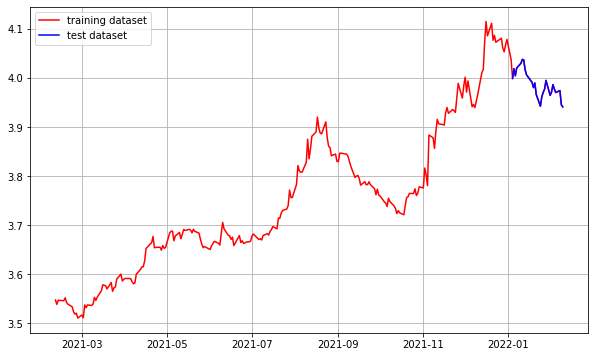

In [6]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [14]:
model = pm.auto_arima (train_data, d = 0, seasonal = False, trace = True)
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1178.754, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1246.326, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1186.520, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1188.447, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1176.568, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1156.817, Time=0.26 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.447 seconds


ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  227
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 597.223
Date:                Thu, 17 Feb 2022   AIC                          -1188.447
Time:                        09:00:08   BIC                          -1178.172
Sample:                             0   HQIC                         -1184.301
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   9191.939      0.000       1.000       1.000
ma.L1         -0.1374      0.051     -2.675      0.007      -0.238      -0.037
sigma2         0.0003   1.42e-05     20.335      0.0

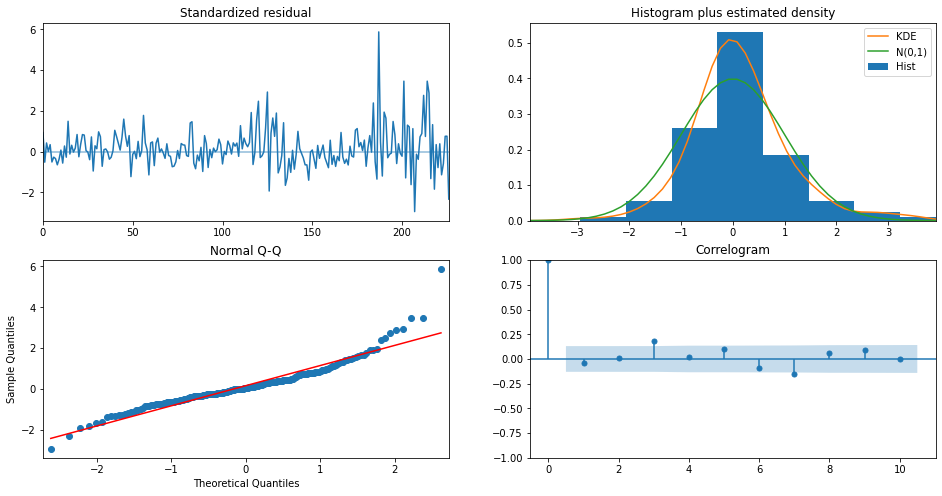

In [16]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

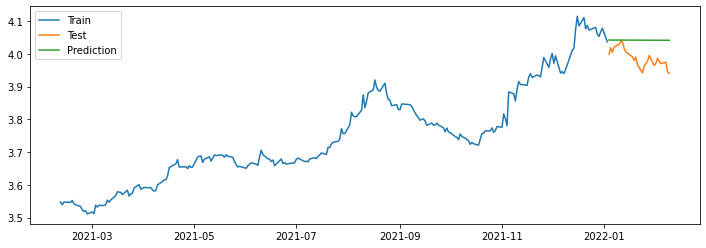

In [17]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(test_data)) 
y_predict = pd.DataFrame(y_predict,index = test_data.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_data, label='Train')        # 훈련 데이터
plt.plot(test_data, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [18]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods = 1, return_conf_int = True)  # 한 스텝씩 예측 진행                
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

In [19]:
forecasts = []
test_pred = []
pred_upper = []
pred_lower = []

for new_ob in test_data:
    fc, conf = forecast_one_step()
    test_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [20]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = train_data.index, y = train_data, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = test_data.index, y = test_data, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = test_data.index, y = test_data, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = test_data.index.tolist() + test_data.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()